# Introduction
This is an example notebook for getting started with analysis of AusPlots data through the ausplotsR R package. The intention is to give step by step guides to loading the package, accessing AusPlots data, generating matrices or indices for analysis and then running simple example downstream analysis and visualisation.

# Loading the package
Ecocloud has `ausplotsR` already installed so to get started, you simply need to load the package.

In [2]:
library(ausplotsR)

Loading required package: plyr
Loading required package: R.utils
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.22.0 (2018-04-21) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, gc, load, save

R.utils v2.7.0 successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, parse, warnings

Loading required package: simba
Loading required package: vegan
Loading required package: permute

Attaching package: ‘permute’

The following object is masked from ‘package:R.oo’:

    check

Loading required package: lattice
This 

We can now access data, starting with basic site information and vegetation point intercept. Note that this will take the best part of a minute to run as we're pulling in the complete Ausplots dataset.

In [7]:
my.ausplots.data <- get_ausplots(veg.vouchers=F)
# note you can get data *only* for specified plot IDs with
#   my.ausplots.data <- get_ausplots(my.Plot_IDs=c("SATFLB0004", "QDAMGD0022", "NTASTU0002"), veg.vouchers=F)

The output of the above call is a list with the following `$elements`:

In [8]:
names(my.ausplots.data)

[1] "site.info" "veg.PI"

# Example 1: latitudinal pattern in proportional vegetation cover
Let's visualise vegetation cover as a function of latitude. First, we call the `fractional_cover` function on the extracted point intercept data. Note the calculation may take a few minutes for all AusPlots, so for this example we will pull out a subset of 100 randomly drawn sites to work with.

In [9]:
my.fractional <- fractional_cover(
    my.ausplots.data$veg.PI[which(my.ausplots.data$veg.PI$site_location_name %in% sample(my.ausplots.data$site.info$site_location_name, 100)), ])
head(my.fractional)

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”

,Plot,bare,brown,green,NA.
NSABHC0002-53597,NSABHC0002-53597,0.00,0.00,30.10,69.9
NSABHC0003-53598,NSABHC0003-53598,46.57,28.14,25.29,0.0
NSABHC0005-53600,NSABHC0005-53600,20.30,32.77,46.93,0.0
NSABHC0010-53605,NSABHC0010-53605,75.27,9.89,14.84,0.0
NSABHC0012-53607,NSABHC0012-53607,19.51,47.55,32.94,0.0
NSABHC0012-58022,NSABHC0012-58022,28.71,32.67,38.61,0.0


Next, we need to merge the fractional cover scores with long, lat coordinates from the site information table. Vegetation survey data is identified by a unique combination of site ID and visit ID, which we need to untangle to get coordinates:

In [10]:
my.fractional$site_location_name <- unlist(lapply(strsplit(my.fractional$Plot, "-"), function(x) paste(x[1])))
my.fractional <- merge(my.fractional, my.ausplots.data$site.info, by="site_location_name")[,c("Plot", "bare", "brown", "green", "NA.", "longitude", "latitude")]
my.fractional <- na.omit(my.fractional)
head(my.fractional)

Plot,bare,brown,green,NA.,longitude,latitude
NSABHC0002-53597,0.00,0.00,30.10,69.9,141.4330,-31.92703
NSABHC0003-53598,46.57,28.14,25.29,0.0,141.4340,-31.82872
NSABHC0005-53600,20.30,32.77,46.93,0.0,141.9405,-31.84496
NSABHC0010-53605,75.27,9.89,14.84,0.0,141.7003,-31.07672
NSABHC0012-53607,19.51,47.55,32.94,0.0,141.7411,-31.07957
NSABHC0012-53607,19.51,47.55,32.94,0.0,141.7411,-31.07957


Now we can plot out the continental relationship, e.g., between the proportion of bare ground with no kind of vegetation cover above and latitude.

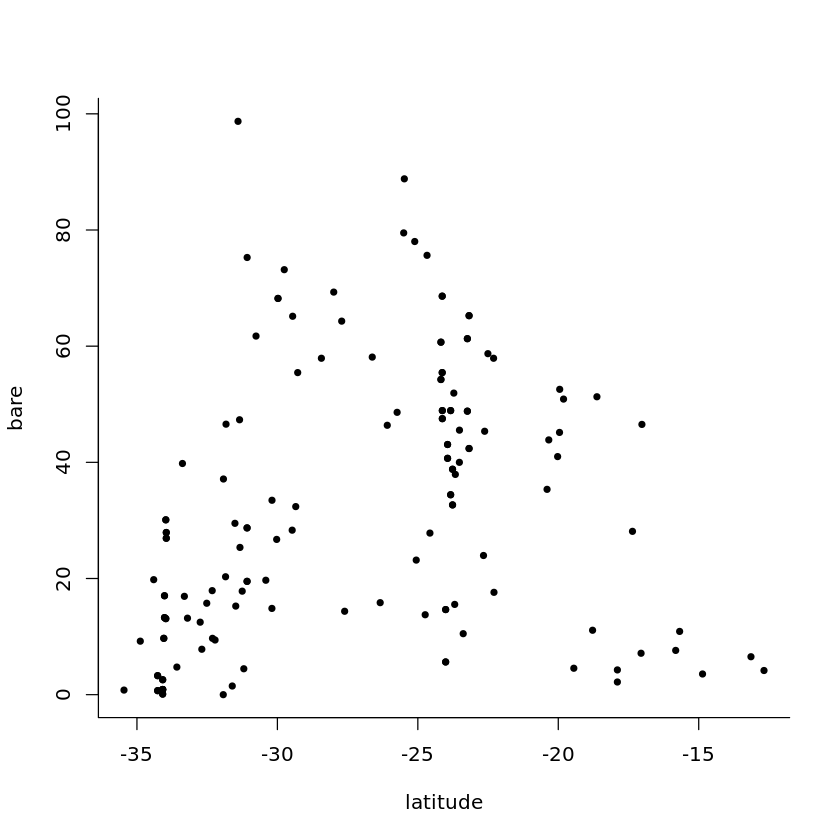

In [11]:
plot(bare ~ latitude, data=my.fractional, pch=20, bty="l")

As you can see, there appears to be a hump-backed relationship, with a higher proportion of bare ground in the arid inland at mid-latitudes. We can add a simple quadratic model to test/approximate this:


Call:
lm(formula = bare ~ latitude + quadratic, data = my.fractional)

Residuals:
   Min     1Q Median     3Q    Max 
-40.56 -11.68  -1.43  14.13  69.16 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -202.63594   31.51644  -6.430 1.71e-09 ***
latitude     -20.00757    2.45550  -8.148 1.52e-13 ***
quadratic     -0.40168    0.04643  -8.652 8.44e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.27 on 146 degrees of freedom
Multiple R-squared:  0.3857,	Adjusted R-squared:  0.3773 
F-statistic: 45.83 on 2 and 146 DF,  p-value: 3.562e-16


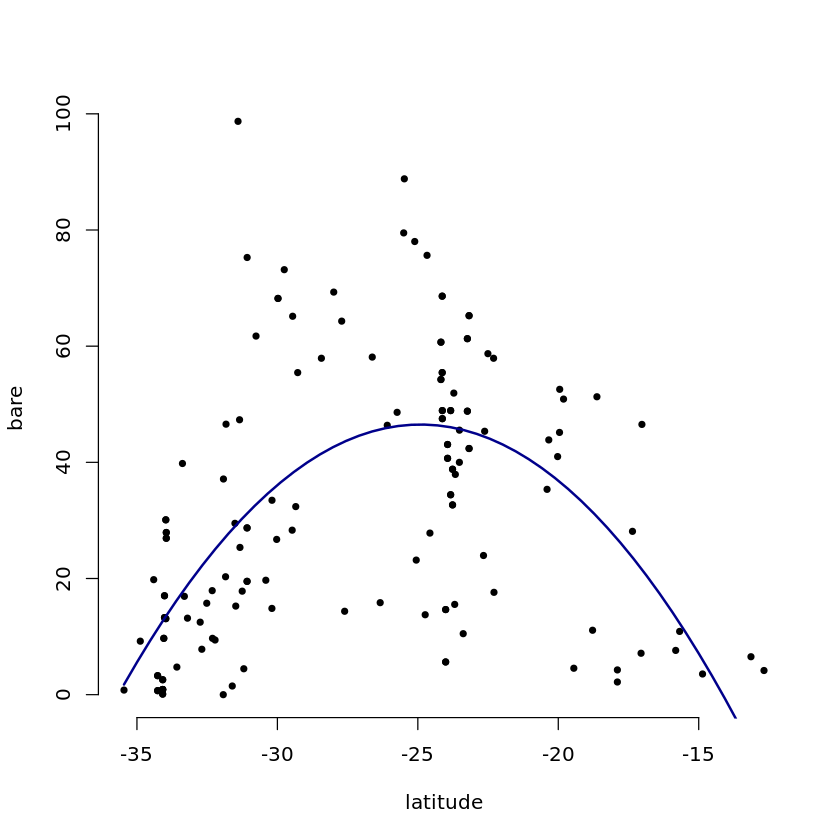

In [12]:
my.fractional$quadratic <- my.fractional$latitude^2
LM <- lm(bare ~ latitude + quadratic, data=my.fractional)
summary(LM)

#generate predicted values for plotting:
ND <- data.frame(latitude=seq(from=min(my.fractional$latitude), to=max(my.fractional$latitude), length.out=50), quadratic=seq(from=min(my.fractional$latitude), to=max(my.fractional$latitude), length.out=50)^2)
ND$predict <- predict(LM, newdata=ND)

plot(bare ~ latitude, data=my.fractional, pch=20, bty="n")
points(ND$latitude, ND$predict , type="l", lwd=2, col="darkblue")

# Example 2: Species by sites table
Aside from gross values from plots such as fractional cover, many analyses in community ecology begin with a species against sites table populated with abundance information. With ausplotsR you can generate this easily from the more complex vegetation point intercept hit data as follows:

In [13]:
my.sppBYsites <- species_table(my.ausplots.data$veg.PI, m_kind="percent_cover", cover_type="PFC")


[1]  574 3025

Let's see how big the matrix is (row and columns count):

In [16]:
dim(my.sppBYsites)

[1]  574 3025

That's pretty large, so let's just look at the top, left corner:

In [17]:
my.sppBYsites[1:5, 1:5]

,Abutilon.fraseri,Abutilon.halophilum,Abutilon.hannii,Abutilon.hannii.subsp..prostrate..p.k.latz.427.,Abutilon.leucopetalum
NSABHC0001-53596,0,0,0,0,0
NSABHC0002-53597,0,0,0,0,0
NSABHC0003-53598,0,0,0,0,0
NSABHC0004-53599,0,0,0,0,0
NSABHC0005-53600,0,0,0,0,0


Here is an example of downstream analysis and visualisation using the species occurrence matrix:

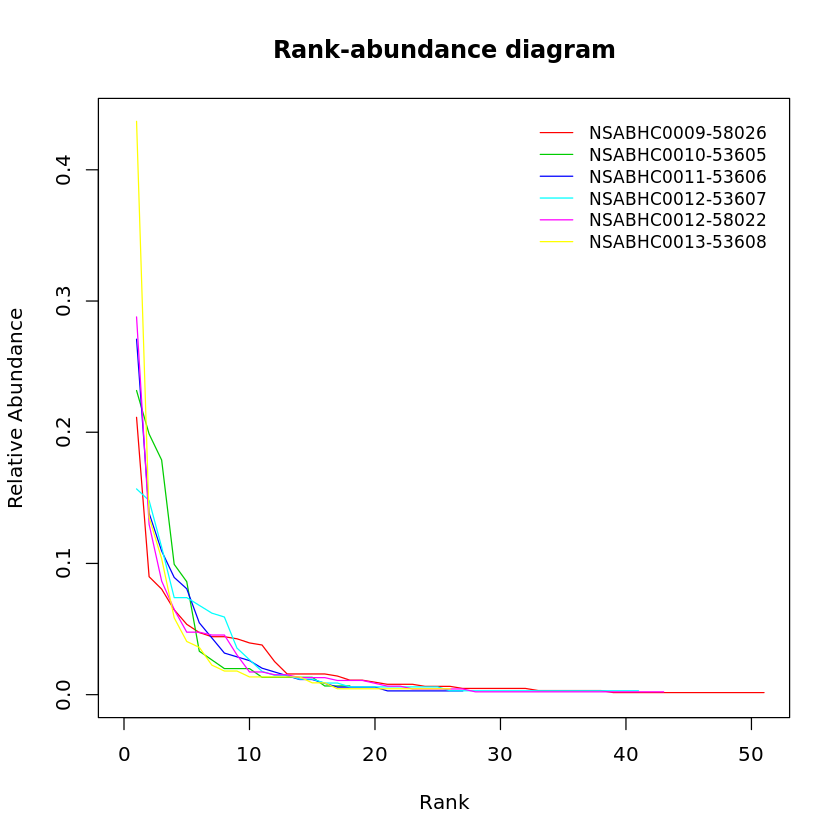

In [15]:
#Whittaker plots:
goeveg::racurves(my.sppBYsites[10:15,], bw=F)